<a href="https://colab.research.google.com/github/sivavithu/Improving-QoS-in-SDN/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ All libraries imported successfully!")
print("🚀 Ready to start traffic classification pipeline")

✅ All libraries imported successfully!
🚀 Ready to start traffic classification pipeline


In [5]:
# ==============================================================================
# CELL 2: Upload and Load Dataset
# Upload your DarkNet-2020 or other traffic dataset
# ==============================================================================


# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Research/Darknet.CSV')

print("✅ Dataset loaded successfully!")
print(f"📏 Dataset shape: {df.shape}")
print(f"📋 Columns: {df.shape[1]} features")


✅ Dataset loaded successfully!
📏 Dataset shape: (158616, 85)
📋 Columns: 85 features


In [6]:
# ==============================================================================
# CELL 3: Dataset Exploration and Visualization
# Comprehensive data exploration with interactive plots
# ==============================================================================

print("🔍 DATASET EXPLORATION")
print("=" * 50)

# Basic dataset information
print("📊 Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

# Display first few rows
print("\n📋 First 5 rows:")
df.head()

# Check data types
print(f"\n📈 Data Types:")
print(df.dtypes.value_counts())

# Check for missing values
missing_data = df.isnull().sum()
print(f"\n❌ Missing Values: {missing_data.sum()} total")

if missing_data.sum() > 0:
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': (missing_data.values / len(df)) * 100
    })
    print(missing_df[missing_df['Missing_Count'] > 0])


🔍 DATASET EXPLORATION
📊 Dataset Info:
Shape: (158616, 85)
Memory usage: 102.86 MB

📋 First 5 rows:

📈 Data Types:
int64      55
float64    24
object      6
Name: count, dtype: int64

❌ Missing Values: 48 total
          Column  Missing_Count  Missing_Percentage
20  Flow Bytes/s             48            0.030262


In [7]:
# Identify target column
possible_targets = ['Label', 'label', 'target', 'class', 'Class']
target_column = None

for col in possible_targets:
    if col in df.columns:
        target_column = col
        break

if target_column is None:
    target_column = df.columns[-1]  # Assume last column is target

print(f"\n🎯 Target column identified: '{target_column}'")

# Target distribution
target_counts = df[target_column].value_counts()
print(f"\n📊 Class Distribution:")
for class_name, count in target_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {class_name}: {count} ({percentage:.2f}%)")


🎯 Target column identified: 'Label'

📊 Class Distribution:
  Non-Tor: 110442 (69.63%)
  NonVPN: 23863 (15.04%)
  VPN: 22919 (14.45%)
  Tor: 1392 (0.88%)


📊 CREATING INTERACTIVE VISUALIZATIONS


📈 Correlation analysis for 79 numeric features
📝 Note: Showing correlation for 20 randomly sampled features


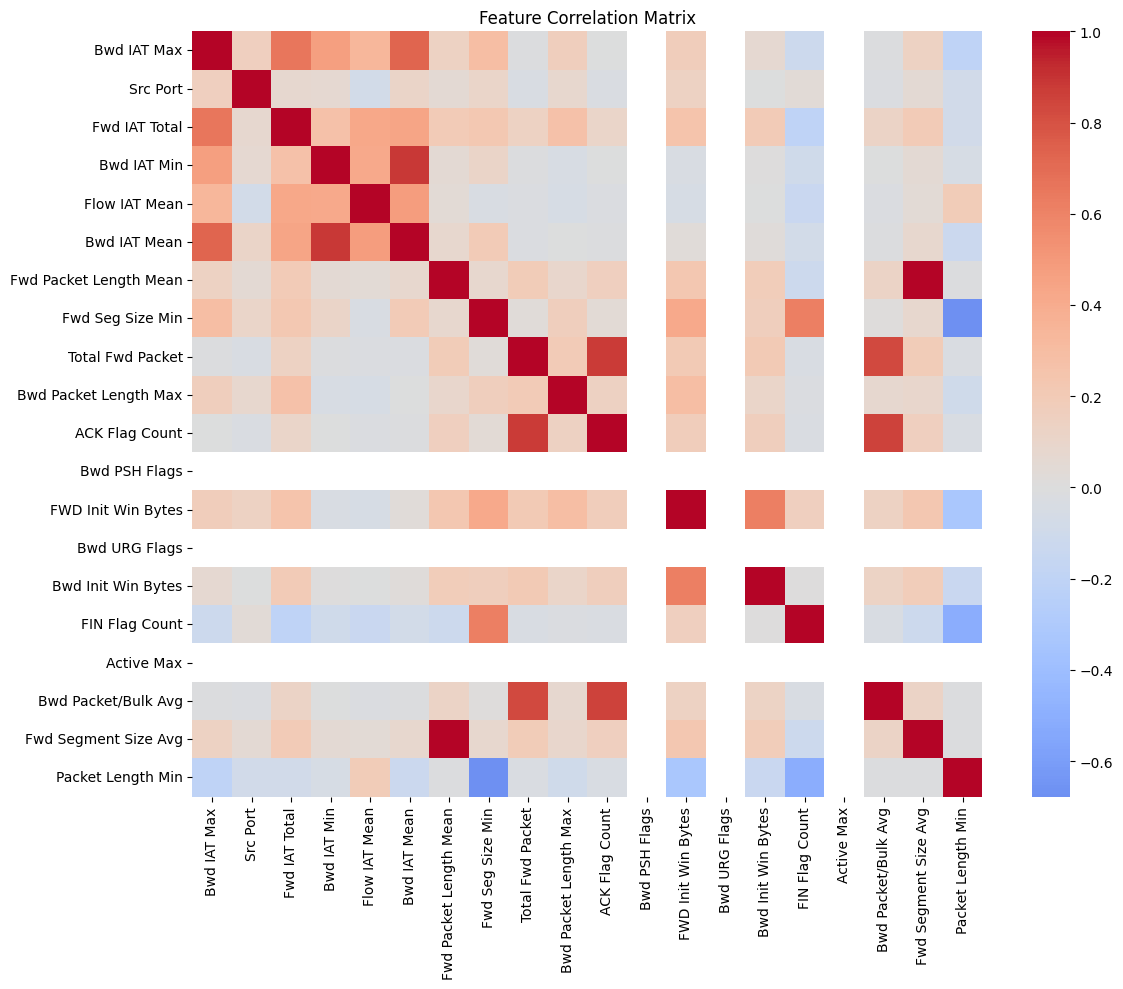

📊 Feature Distribution Analysis


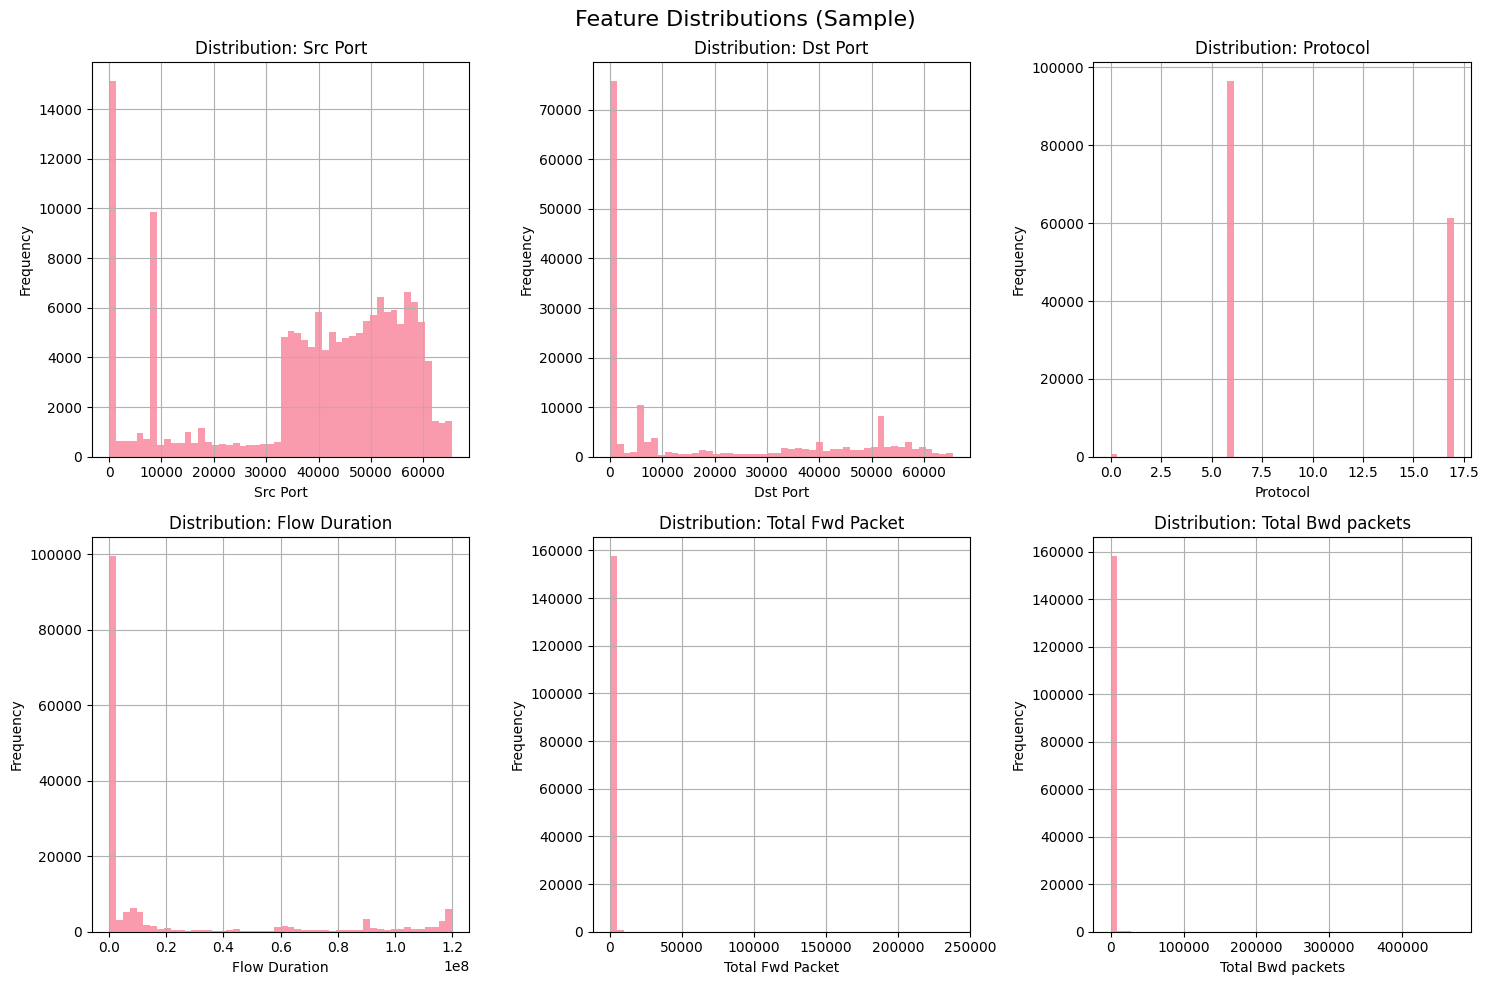

✅ Data exploration completed!


In [8]:
# ==============================================================================
# CELL 4: Interactive Data Visualization
# Create comprehensive visualizations
# ==============================================================================

print("📊 CREATING INTERACTIVE VISUALIZATIONS")
print("=" * 50)

# Set up visualization style
plt.style.use('default')
sns.set_palette("husl")

# 1. Class Distribution Pie Chart
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Class Distribution', 'Feature Data Types',
                   'Missing Values Heatmap', 'Dataset Statistics'),
    specs=[[{"type": "pie"}, {"type": "bar"}],
           [{"type": "heatmap"}, {"type": "bar"}]]
)

# Pie chart for class distribution
fig.add_trace(
    go.Pie(labels=target_counts.index, values=target_counts.values, name="Classes"),
    row=1, col=1
)

# Bar chart for data types
dtype_counts = df.dtypes.value_counts()
fig.add_trace(
    go.Bar(x=dtype_counts.index.astype(str), y=dtype_counts.values, name="Data Types"),
    row=1, col=2
)

fig.update_layout(height=800, showlegend=True, title_text="Dataset Overview Dashboard")
fig.show()

# 2. Feature correlation heatmap (for numeric features only)
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    print(f"📈 Correlation analysis for {len(numeric_cols)} numeric features")

    # Sample correlation matrix (if too many features, sample them)
    if len(numeric_cols) > 20:
        sample_cols = np.random.choice(numeric_cols, 20, replace=False)
        corr_matrix = df[sample_cols].corr()
        print("📝 Note: Showing correlation for 20 randomly sampled features")
    else:
        corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

# 3. Feature distribution plots
print("📊 Feature Distribution Analysis")
numeric_features = df.select_dtypes(include=[np.number]).columns.drop(target_column, errors='ignore')

if len(numeric_features) > 0:
    # Select top 6 features for visualization
    sample_features = numeric_features[:6] if len(numeric_features) >= 6 else numeric_features

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i, feature in enumerate(sample_features):
        if i < 6:  # Only plot first 6 features
            df[feature].hist(bins=50, alpha=0.7, ax=axes[i])
            axes[i].set_title(f'Distribution: {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')

    # Hide empty subplots
    for j in range(i+1, 6):
        axes[j].set_visible(False)

    plt.suptitle('Feature Distributions (Sample)', fontsize=16)
    plt.tight_layout()
    plt.show()

print("✅ Data exploration completed!")

In [10]:
# ==============================================================================
# CELL 5: Data Preprocessing
# Clean and prepare data for machine learning
# ==============================================================================

print("🔧 DATA PREPROCESSING")
print("=" * 50)

# Create a copy for preprocessing
df_processed = df.copy()

# Separate features and target
X = df_processed.drop(target_column, axis=1)
y = df_processed[target_column]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Handle categorical features
categorical_features = X.select_dtypes(exclude=[np.number]).columns
numeric_features = X.select_dtypes(include=[np.number]).columns

print(f"📊 Numeric features: {len(numeric_features)}")
print(f"📝 Categorical features: {len(categorical_features)}")

if len(categorical_features) > 0:
    print("🔄 Encoding categorical features...")
    for col in categorical_features:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

# Handle infinite values
print("🔄 Handling infinite values...")
X = X.replace([np.inf, -np.inf], np.nan)

# Handle missing values
missing_count_before = X.isnull().sum().sum()
if missing_count_before > 0:
    print(f"🔄 Filling {missing_count_before} missing values with median...")
    X = X.fillna(X.median())

# Remove duplicate rows
duplicate_count = X.duplicated().sum()
if duplicate_count > 0:
    print(f"🔄 Removing {duplicate_count} duplicate rows...")
    duplicate_indices = X.duplicated()
    X = X[~duplicate_indices]
    y = y[~duplicate_indices]

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

print(f"✅ Preprocessing completed!")
print(f"📏 Final dataset shape: {X.shape}")
print(f"🎯 Classes: {list(class_names)}")
print(f"🔢 Number of classes: {len(class_names)}")
# Store feature names for later use
feature_names = X.columns.tolist()

🔧 DATA PREPROCESSING
Features shape: (158616, 84)
Target shape: (158616,)
📊 Numeric features: 79
📝 Categorical features: 5
🔄 Encoding categorical features...
🔄 Handling infinite values...
🔄 Filling 100 missing values with median...
🔄 Removing 39004 duplicate rows...
✅ Preprocessing completed!
📏 Final dataset shape: (119612, 84)
🎯 Classes: ['Non-Tor', 'NonVPN', 'Tor', 'VPN']
🔢 Number of classes: 4


🎯 FEATURE SELECTION
🌳 Computing Random Forest feature importance...
📊 Selected top 20 features out of 84


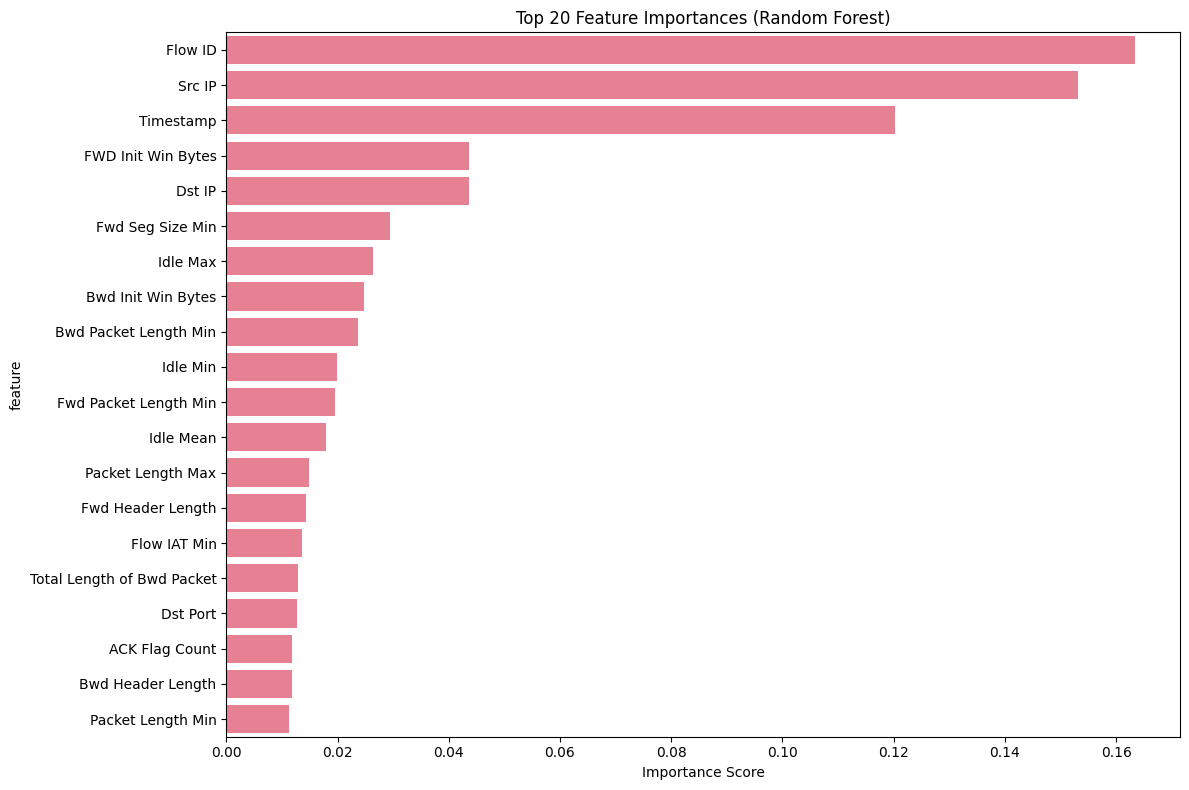

✅ Feature selection completed!
📊 Selected features shape: (119612, 20)


In [11]:

# ==============================================================================
# CELL 6: Feature Selection with Visualization
# Select most important features for classification
# ==============================================================================

print("🎯 FEATURE SELECTION")
print("=" * 50)

# Method 1: Random Forest Feature Importance
print("🌳 Computing Random Forest feature importance...")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_selector.fit(X, y_encoded)

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

# Select top k features (20 or total features if less than 20)
k = min(20, len(feature_names))
top_features = feature_importances.head(k)['feature'].tolist()

print(f"📊 Selected top {k} features out of {len(feature_names)}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_20_features = feature_importances.head(20)
sns.barplot(data=top_20_features, y='feature', x='importance')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Interactive feature importance plot
fig = px.bar(
    top_20_features,
    x='importance',
    y='feature',
    orientation='h',
    title='Top 20 Feature Importances',
    labels={'importance': 'Importance Score', 'feature': 'Features'}
)
fig.update_layout(height=600)
fig.show()

# Select features for final model
X_selected = X[top_features]
print(f"✅ Feature selection completed!")
print(f"📊 Selected features shape: {X_selected.shape}")


📊 TRAIN-TEST SPLIT AND SCALING
📈 Dataset splits:
  Training:   83727 samples (70.0%)
  Validation: 11962 samples (10.0%)
  Test:       23923 samples (20.0%)


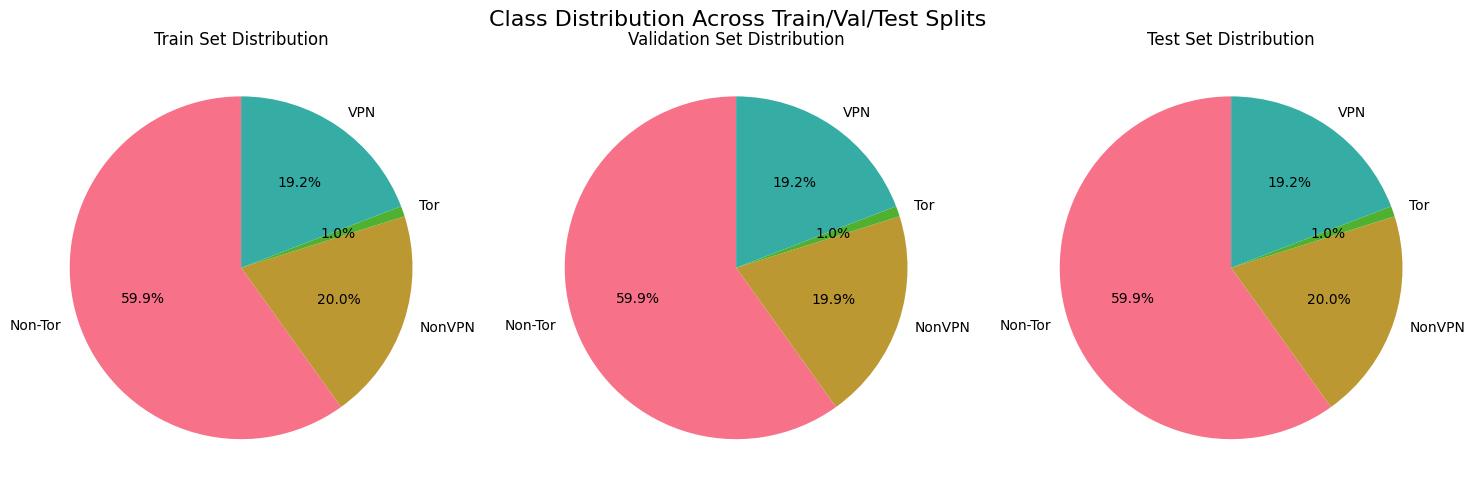

⚖️ Scaling features using StandardScaler...
✅ Data splitting and scaling completed!


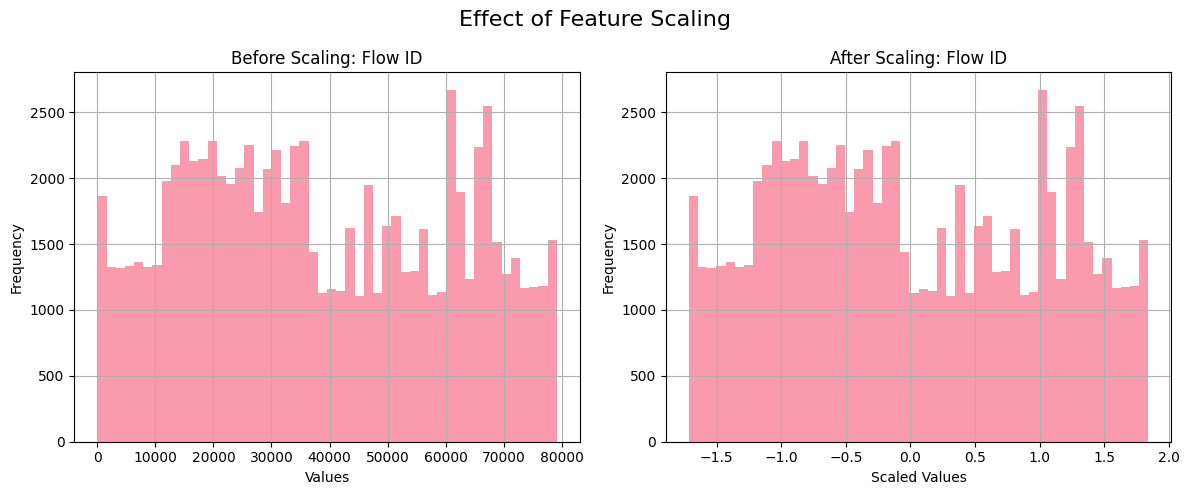

In [12]:
# ==============================================================================
# CELL 7: Train-Test Split and Data Scaling
# Split data and scale features
# ==============================================================================

print("📊 TRAIN-TEST SPLIT AND SCALING")
print("=" * 50)

# Split into train, validation, and test sets
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)

# Second split: 70% train, 10% validation from the remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"📈 Dataset splits:")
print(f"  Training:   {X_train.shape[0]:5d} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validation: {X_val.shape[0]:5d} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Test:       {X_test.shape[0]:5d} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Visualize class distribution in splits
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, y_data) in enumerate([('Train', y_train), ('Validation', y_val), ('Test', y_test)]):
    unique, counts = np.unique(y_data, return_counts=True)
    class_labels = [class_names[j] for j in unique]

    axes[i].pie(counts, labels=class_labels, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f'{name} Set Distribution')

plt.suptitle('Class Distribution Across Train/Val/Test Splits', fontsize=16)
plt.tight_layout()
plt.show()

# Scale the features
print("⚖️ Scaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=top_features)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=top_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=top_features)

print("✅ Data splitting and scaling completed!")

# Visualize scaling effect
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before scaling
X_train.iloc[:, 0].hist(bins=50, alpha=0.7, ax=axes[0])
axes[0].set_title(f'Before Scaling: {top_features[0]}')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')

# After scaling
X_train_scaled.iloc[:, 0].hist(bins=50, alpha=0.7, ax=axes[1])
axes[1].set_title(f'After Scaling: {top_features[0]}')
axes[1].set_xlabel('Scaled Values')
axes[1].set_ylabel('Frequency')

plt.suptitle('Effect of Feature Scaling', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:

# ==============================================================================
# CELL 8: Hyperparameter Tuning with Progress Visualization
# Optimize Random Forest hyperparameters
# ==============================================================================

print("⚙️ HYPERPARAMETER TUNING")
print("=" * 50)

# Define parameter grid for Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

print("🔍 Parameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = np.prod([len(values) for values in param_grid.values()])
print(f"\n📊 Total combinations to test: {total_combinations}")

# Perform Grid Search
print("🔄 Performing Grid Search with 5-fold Cross-Validation...")
print("⏱️ This may take a few minutes...")

rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

print("✅ Grid Search completed!")
print(f"🏆 Best CV Score: {grid_search.best_score_:.4f}")
print(f"🎯 Best Parameters: {grid_search.best_params_}")

# Visualize hyperparameter tuning results
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot validation scores
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(results_df['mean_test_score'], bins=20, alpha=0.7, edgecolor='black')
plt.axvline(grid_search.best_score_, color='red', linestyle='--',
           label=f'Best Score: {grid_search.best_score_:.4f}')
plt.xlabel('Mean CV F1-Score')
plt.ylabel('Frequency')
plt.title('Distribution of CV Scores')
plt.legend()

# Plot train vs validation scores
plt.subplot(1, 2, 2)
plt.scatter(results_df['mean_train_score'], results_df['mean_test_score'], alpha=0.6)
plt.xlabel('Mean Train Score')
plt.ylabel('Mean Validation Score')
plt.title('Train vs Validation Scores')
plt.plot([0, 1], [0, 1], 'r--', alpha=0.8)
plt.tight_layout()
plt.show()

# Store best model
best_model = grid_search.best_estimator_


⚙️ HYPERPARAMETER TUNING
🔍 Parameter Grid:
  n_estimators: [50, 100, 200]
  max_depth: [10, 20, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2']
  bootstrap: [True, False]

📊 Total combinations to test: 324
🔄 Performing Grid Search with 5-fold Cross-Validation...
⏱️ This may take a few minutes...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [ ]:
# ==============================================================================
# CELL 9: Model Training and Cross-Validation
# Train the final model with best parameters
# ==============================================================================

print("🚀 FINAL MODEL TRAINING")
print("=" * 50)

# Train the best model
print("🌳 Training Random Forest with optimized parameters...")
best_model.fit(X_train_scaled, y_train)

print("✅ Model training completed!")
print(f"📊 Model Details:")
print(f"  Number of estimators: {best_model.n_estimators}")
print(f"  Max depth: {best_model.max_depth}")
print(f"  Min samples split: {best_model.min_samples_split}")
print(f"  Min samples leaf: {best_model.min_samples_leaf}")
print(f"  Max features: {best_model.max_features}")

# Perform cross-validation on the best model
print("\n🔄 Performing Cross-Validation Analysis...")
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='f1_weighted')

print(f"📊 Cross-Validation Results:")
print(f"  Mean F1-Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"  Individual Scores: {[f'{score:.4f}' for score in cv_scores]}")

# Visualize CV scores
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.bar(range(1, 6), cv_scores)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('Cross-Validation Scores')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(cv_scores)
plt.ylabel('F1-Score')
plt.title('CV Score Distribution')
plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# CELL 10: Model Evaluation and Performance Metrics
# Comprehensive model evaluation
# ==============================================================================

print("📊 MODEL EVALUATION")
print("=" * 50)

# Make predictions on all sets
y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)
y_test_pred = best_model.predict(X_test_scaled)

# Calculate metrics for all sets
def calculate_metrics(y_true, y_pred, set_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\n📈 {set_name} Set Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    return accuracy, precision, recall, f1

# Calculate metrics for all datasets
train_metrics = calculate_metrics(y_train, y_train_pred, "Training")
val_metrics = calculate_metrics(y_val, y_val_pred, "Validation")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test")

# Create performance comparison
metrics_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Test'],
    'Accuracy': [train_metrics[0], val_metrics[0], test_metrics[0]],
    'Precision': [train_metrics[1], val_metrics[1], test_metrics[1]],
    'Recall': [train_metrics[2], val_metrics[2], test_metrics[2]],
    'F1-Score': [train_metrics[3], val_metrics[3], test_metrics[3]]
})

# Visualize performance metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Performance comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics_df))
width = 0.25

for i, metric in enumerate(metrics_to_plot):
    row, col = i // 2, i % 2
    axes[row, col].bar(x, metrics_df[metric], width=0.6, alpha=0.8)
    axes[row, col].set_xlabel('Dataset')
    axes[row, col].set_ylabel(metric)
    axes[row, col].set_title(f'{metric} Across Datasets')
    axes[row, col].set_xticks(x)
    axes[row, col].set_xticklabels(metrics_df['Dataset'])
    axes[row, col].set_ylim(0, 1.1)

    # Add value labels on bars
    for j, v in enumerate(metrics_df[metric]):
        axes[row, col].text(j, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.suptitle('Model Performance Comparison', fontsize=16)
plt.tight_layout()
plt.show()

# Detailed classification report
print(f"\n📋 DETAILED CLASSIFICATION REPORT (Test Set):")
print("=" * 50)
report = classification_report(y_test, y_test_pred, target_names=class_names, output_dict=True)
print(classification_report(y_test, y_test_pred, target_names=class_names))


In [ ]:

# ==============================================================================
# CELL 11: Advanced Visualizations
# Create comprehensive visualization dashboard
# ==============================================================================

print("📊 ADVANCED VISUALIZATIONS")
print("=" * 50)

# Set up the figure
fig = plt.figure(figsize=(20, 15))

# 1. Confusion Matrix
plt.subplot(3, 3, 1)
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# 2. Feature Importance (Top 15)
plt.subplot(3, 3, 2)
top_15_features = feature_importances.head(15)
plt.barh(range(len(top_15_features)), top_15_features['importance'])
plt.yticks(range(len(top_15_features)), top_15_features['feature'])
plt.xlabel('Importance Score')
plt.title('Top 15 Feature Importances', fontsize=14)
plt.gca().invert_yaxis()

# 3. Learning Curves (Training History)
plt.subplot(3, 3, 3)
metrics_comparison = metrics_df.set_index('Dataset').T
metrics_comparison.plot(kind='bar', ax=plt.gca())
plt.title('Performance Metrics Comparison', fontsize=14)
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Class Distribution in Test Set
plt.subplot(3, 3, 4)
test_class_counts = np.bincount(y_test)
class_labels = [class_names[i] for i in range(len(test_class_counts))]
plt.pie(test_class_counts, labels=class_labels, autopct='%1.1f%%', startangle=90)
plt.title('Test Set Class Distribution', fontsize=14)

# 5. Precision-Recall by Class
plt.subplot(3, 3, 5)
class_report_df = pd.DataFrame(report).transpose()
class_metrics = class_report_df.iloc[:-3]  # Exclude avg rows
x_pos = np.arange(len(class_metrics))
width = 0.35

plt.bar(x_pos - width/2, class_metrics['precision'], width, label='Precision', alpha=0.8)
plt.bar(x_pos + width/2, class_metrics['recall'], width, label='Recall', alpha=0.8)
plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Precision & Recall by Class', fontsize=14)
plt.xticks(x_pos, class_metrics.index, rotation=45)
plt.legend()

# 6. Model Complexity vs Performance
plt.subplot(3, 3, 6)
plt.scatter(results_df['mean_fit_time'], results_df['mean_test_score'], alpha=0.6)
plt.xlabel('Training Time (seconds)')
plt.ylabel('CV F1-Score')
plt.title('Model Complexity vs Performance', fontsize=14)

# 7. Prediction Confidence Distribution
plt.subplot(3, 3, 7)
y_test_proba = best_model.predict_proba(X_test_scaled)
max_probabilities = np.max(y_test_proba, axis=1)
plt.hist(max_probabilities, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Maximum Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Confidence Distribution', fontsize=14)

# 8. Error Analysis
plt.subplot(3, 3, 8)
errors = y_test != y_test_pred
error_by_class = []
for i, class_name in enumerate(class_names):
    class_mask = y_test == i
    if np.sum(class_mask) > 0:
        error_rate = np.sum(errors[class_mask]) / np.sum(class_mask)
        error_by_class.append(error_rate)
    else:
        error_by_class.append(0)

plt.bar(range(len(class_names)), error_by_class)
plt.xlabel('Classes')
plt.ylabel('Error Rate')
plt.title('Error Rate by Class', fontsize=14)
plt.xticks(range(len(class_names)), class_names, rotation=45)

# 9. Cross-Validation Stability
plt.subplot(3, 3, 9)
plt.plot(range(1, 6), cv_scores, 'o-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', alpha=0.7)
plt.fill_between(range(1, 6), cv_scores.mean() - cv_scores.std(),
                cv_scores.mean() + cv_scores.std(), alpha=0.2)
plt.xlabel('CV Fold')
plt.ylabel('F1-Score')
plt.title('Cross-Validation Stability', fontsize=14)
plt.grid(True, alpha=0.3)

plt.suptitle('Comprehensive Model Analysis Dashboard', fontsize=20, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("✅ Advanced visualizations completed!")

In [ ]:
# ==============================================================================
# CELL 12: Interactive Plotly Dashboard
# Create interactive plots for better exploration
# ==============================================================================

print("🎨 INTERACTIVE DASHBOARD")
print("=" * 50)

# Create interactive confusion matrix
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
fig_cm = px.imshow(cm_df,
                   labels=dict(x="Predicted", y="Actual", color="Count"),
                   x=class_names, y=class_names,
                   title="Interactive Confusion Matrix")
fig_cm.update_layout(width=600, height=500)
fig_cm.show()

# Interactive feature importance
fig_importance = px.bar(
    feature_importances.head(20),
    x='importance',
    y='feature',
    orientation='h',
    title='Interactive Feature Importance (Top 20)',
    labels={'importance': 'Importance Score', 'feature': 'Features'}
)
fig_importance.update_layout(height=700)
fig_importance.show()

# Interactive performance comparison
fig_performance = px.bar(
    metrics_df.melt(id_vars=['Dataset'], var_name='Metric', value_name='Score'),
    x='Dataset', y='Score', color='Metric', barmode='group',
    title='Interactive Performance Metrics Comparison'
)
fig_performance.update_layout(height=500)
fig_performance.show()

print("✅ Interactive dashboard completed!")